## Домашнее задание по свёрточным сетям

Сутью домашнего задания является последовательная реализация базовых операций, применяемых в свёрточных сетях с использованием операций над тензорами PyTorch, но без применения модулей torch.nn. Студенты должны самостоятельно реализовать как прямой и обратный проходы слоёв, так и классы нейронных сетей.

Правильность выполнения задания будет проверяться идентичностью прохождения процесса обучения в тех же архитектурах, выполненных с применением модулей и алгоритмов PyTorch.

### Задание 1

В первом задании требуется реализовать классы двухмерной свёртки **Conv**, линейного слоя **Fc**, алгоритм обучения нейронной сети **SGD**, функцию активации **ReLU**, **Softmax** и функцию эмпирического риска **CrossEntropyLoss**.

Свёрточные и полносвязные слои должны реализовывать операцию сдвига (*bias*, *b*). 
Сверить формулы прямого прохода можно в документации по [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) и [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).

Далее, следует реализовать класс модели, который включает в себя реализованные выше компоненты. Требуется повторить параметры обучения и архитектуру, реализованную ниже с помощью torch.nn модулей. Критерием правильности решения будет совпадение значений эмпирического риска при обучении обеих реализаций сетей на одних и тех же данных, с теми же параметрами и с одинаковыми начальными инициализациями весов.

Данные для обучения состоят из 4 примеров вертикальных и горизонтальных линий. 


In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
import math
import copy

_ = torch.manual_seed(1)

In [2]:
def one_hot_encoding(y, num_classes):
    N = y.shape[0]
    Z = torch.zeros((N, num_classes))
    Z[torch.arange(N), y] = 1
    return Z

Train data shape [Batch, Channels, Height, Width] = torch.Size([4, 1, 5, 5])
Labels shape = torch.Size([4])
Mean and standard deviation before normalization = 49.90, 97.45
Mean and standard deviation after normalization = 0.00, 1.00
Train batch


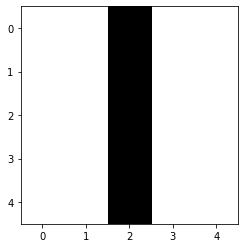

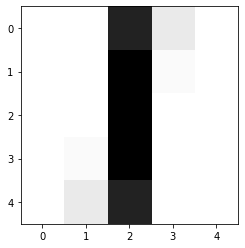

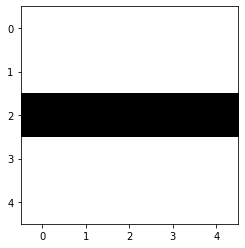

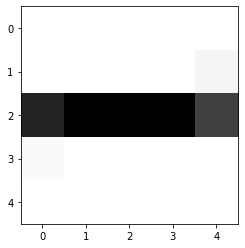

In [3]:
# Обучение будет вестись на следующих данных
def get_data():
    # Задача классификации вертикальных и горизонтальных линий
    # Данные
    vert1 = [[0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0],
             [0, 0, 250, 0, 0]]

    vert2 = [[0, 0, 220, 40, 0],
             [0, 0, 250, 10, 0],
             [0, 0, 250, 0, 0],
             [0, 10, 250, 0, 0],
             [0, 40, 220, 0, 0]]

    hor1 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [250, 250, 250, 250, 250],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    hor2 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 20],
            [220, 250, 250, 250, 200],
            [10, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]

    data = [vert1, vert2, hor1, hor2]
    labels = [0, 0, 1, 1]
    
    train_x = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
    labels = torch.tensor(labels, dtype=torch.long)

    return train_x, labels

train_x, labels = get_data()
print(f'Train data shape [Batch, Channels, Height, Width] = {train_x.shape}')
print(f'Labels shape = {labels.shape}')


train_mean = torch.mean(train_x)
train_std = torch.std(train_x)
batch = (train_x - train_mean) / train_std

print(f'Mean and standard deviation before normalization = {train_mean.item():.2f}, {train_std.item():.2f}')
print(f'Mean and standard deviation after normalization = {torch.mean(batch).item():.2f}, {torch.std(batch).item():.2f}')

print('Train batch')
for img in batch:
    plt.imshow(img.squeeze(0), cmap='Greys')  # Цвета инвертированы. Чем темнее, тем значение пикселя больше
    plt.show() 

Реализуем эталонную модель **TorchGradientModel**, состоящую из следующих модулей:
- Сверточный слой с 4 фильтрами размера $5\times5$;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Линейный слой с 2 выходными нейронами для классов горизонтальной и вертикальной линий

Вопрос:
Каким ещё образом можно осуществить бинарную классификацию, не используя линейный слой, с 2 выходными нейронами?

**Ответ.** Можно подобрать размер свёрток так, чтобы на выходе получалось два канала, в каждом из которых будет тензор вероятности принадлежности к классам (в нашем случае детекция не нужна, поэтому достаточно на выходе получить 2 тензора размера 1 на 1, то есть output.shape = 2x1x1).

А ещё можно попробовать с одним нейроном: применять какую-нибудь сигмоиду и смотреть, если значение > 0.5, то отправляем в класс 1, иначе --- в класс 0.

In [4]:
class TorchGradientModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, padding=0, bias=True)
        self.act1 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 1 * 1, 2)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

Дополнительная информация может быть найдена в комментариях к коду

In [5]:
# Данная сеть обучается за 3 эпохи, что удобно для процесса отладки.
learning_rate = 1
epochs = 3

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
# torch_model_params[0] - тензор с весами фильтров W свёрточного слоя
# torch_model_params[1] - тензор с весами сдвигов b свёрточного слоя
# torch_model_params[2] - тензор с весами W линейного слоя
# torch_model_params[3] - тензор с весами сдвигов b линейного слоя
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета 
# (для I-го слоя - это кол-во изображений),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для данного эксперимента используется самый простой алгоритм обучения без моментов.
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, 
                            momentum=0, dampening=0, weight_decay=0, 
                            nesterov=False)

In [6]:
torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
    # Можете выводить веса сети для прямого сравнения со своей реализацей
    print('Parameters')
    for param in torch_grad_model.named_parameters():
        print(param)
    print('==============================================================')

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты также можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)"
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

100%|██████████| 3/3 [00:00<00:00, 11.88it/s, accuracy=1, loss=0.0179]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.150

Ниже представлены заготовки (шаблоны) классов, колторые требуется реализовать. **Conv**, **Fc** и **ReLU** должны иметь методы **forward** и **backward** для прямого и обратного прохода по сети. При прямом проходе следует кэшировать данные, которые потребуются для вычисления градиента.

**Свёртки**

При прямом проходе нужно брать фильтры поочерёдно и проводить свёртку со входным тензором. Каждая операция свёртки даёт 2-мерную матрицу на выходе. Для получения итоговой карты признаков следует сконкатенировать эти матрицы, чтобы получить тензор рамерами [Размер батча, Количество каналов, Высота, Ширина]. Реализовывать можно как с помощью вложенных циклов, так и с применением векторизации. В данном задании важно не время работы, но точность вычислений.

В первом модуле заданий уже была показана реализация обратного прохода по линейному слою для подсчёта частных производных по эмпирическому риску, которые использовались для обновления весов слоя. Расчёт частных производных в свёрточных слоях идеологически тот же. Требуется посчитать частные производные по dX предыдущему входу слоя, dW по весам фильтров и db по сдвигам. Пусть dZ – это градиент ошибки к выходу текущего свёрточного слоя (передаётся от предыдущего слоя при обратном проходе сети), тогда

$dX += \sum_{h=0}^{n_H}\sum_{w=0}^{n_W} W_c\times dZ_{hw}$,

где $W_c$ – это фильтр, а $dZ_{hw}$ – скаляр, соответствующий градиенту эмпирического риска к выходу текущего свёрточного слоя $Z$ в $n$ строке и $w$ столбце. Так как при прямом проходе фильтр $W_c$ влияет на все значения канала с карты признаков, то мы умножаем один и тот же фильтр $W_c$ с разными $dZ$ в пределах канала $с$, суммируя результаты.
В numpy эта операция выглядела бы так

 dX[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
 
В PyTorch очерёдность каналов иная: [Batch, Channel, Height, Width].

Производная одного фильтра относительно эмпирического риска  считается по формуле

$dW_c+=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}x_{slice} \times dZ_{hw}$,

где $x_{slice}$ относится к отрезку из входного тензора, который был использован в прямом проходе, чтобы получить активацию $Z_{ij}$. Таким образом мы получим градиент фильтра $W$ относительно данного отрезка. Так как в рамках свёрточного слоя для разных отрезков мы использовали тот же фильтр $W$, то мы складываем эти градиенты, чтобы получить $dW$.

В numpy подобная операция реализуется так:

dW[:,:,:,c] += x_slice * dZ[i, h, w, c]

Производная по сдвигам считается как сумма всех градиентов выхода свёрточного слоя:

$db=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}dZ_{hw}$

В numpy реализовывалась бы так:

db[:,:,:,c] += dZ[i, h, w, c]


Для реализации выполнения обратного прохода градиента идентичным nn.CrossEntropyLoss(reduction='mean') образом, значения $dW$ и $db$ следует делить на размер пакета (batch).


**Замечание.** Хочется понять откуда взялись эти формулы... Вот [тут](https://towardsdatascience.com/backpropagation-in-a-convolutional-layer-24c8d64d8509) и [тут](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c) выводят с примерами, но без учёта `stride` и `padding`.

Я сам пытался вывести часа 3 формулы в общем случае, но c градиентом по входу потрепел фиаско. Как же хорошо, что мне скинули в итоге вот эту [статью](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710).

In [125]:
# Наивная реализация свёртки, медленная
class Conv():  # TODO: в чём смысл ставить круглые скобки???
    def __init__(self, nb_filters: int, filter_size: int, nb_channels: int, 
                 stride: int = 1, padding: int = 0, 
                 sanity_check: bool = True):
        self.num_filters = nb_filters
        self.f = filter_size
        self.n_C = nb_channels
        self.s = stride
        self.p = padding
#         self.sanity_check = sanity_check  # использовать не обязательно

        self.cache = None  # Для хранения данных прямого прохода сети, 
                           # которые потребуются при обратном проходе
        
        self.W = torch_model_params[0]  # (n_C, n_C_prev, filter_size, filter_size)
        self.dW = torch.zeros(self.W.shape)
        
        self.b = torch_model_params[1]  # (n_C)
        self.db =  torch.zeros(self.b.shape)

    @staticmethod
    def single_conv(x_slice, W, b):
        """
        Выполняет скалярное произведение двух матриц. 
        Нужна для операции свёртки.
        
        Параметры
        ---------
        x_slice : torch.tensor, shape = (n_C_prev, filter_size, filter_size)
            Часть входных данных, над которыми сейчас идёт свёртка
        W : torch.tensor, shape = (n_C_prev, filter_size, filter_size)
            Параметры свёртки
        b : torch.tensor, shape = (1, 1, 1)
            Параметр смещения для данного фильтра
        
        Возвращает
        ----------
        float
            Результат применения операции свёртки.
        """
        
        # Поэлементное произведение
        s = torch.mul(x_slice, W)
        # Сумма произведений
        g = torch.sum(s)
        # Сдвиг
        g = g + b
        return g
    
    def _dilate(self, X):
        """
        Вставляет в каждом фильтре после каждой строки/столбца 
        stride-1 нулевых строк/столбцов. Нужна для backpropagation.
        
        Параметры
        ---------
        X : torch.tensor, shape = (n_C, H, W)
            Тензор для преобразования.
        
        Возвращает
        ----------
        torch.tensor, shape = (n_C, new_H, new_W)
            Преобразованный тензор.
        """
        
        n_C, H, W = X.shape
        
        new_H, new_W = H + (H - 1) * (self.s - 1), W + (W - 1) * (self.s - 1)
        X_dilated = torch.zeros((n_C, new_H, new_W))
        
#         for c in range(n_C):
        for i in range(0, new_H, self.s):
            for j in range(0, new_W, self.s):
                X_dilated[:, i, j] = X[:, i // self.s, j // self.s]
                
        return X_dilated
    
    @staticmethod
    def rotate180(X):
        """
        Поворачивает тензор на 180 градусов с помощью двух симметричных
        отображений.
        
        Параметры
        ---------
        X : torch.tensor, shape = (H, W)
            Тензор для преобразования.
        
        Возвращает
        ----------
        torch.tensor
            Повёрнутый на 180 градусов тензор.
        """
        
        H, W = X.shape
        
        X_rotated = torch.zeros(X.shape)
        for i in range(H):
            for j in range(W):
                X_rotated[i, j] = X[H - 1 - i, W - 1 - j]
                
        return X_rotated
    
    def forward(self, X):
        """
        Прямой проход для свёрточного слоя.
        
        Параметры
        ---------
        X : torch.tensor, shape = (m, n_C_prev, n_H_prev, n_W_prev).
            Выход предыдущего свёрточного слоя.
        
        Возвращает
        ----------
        torch.tensor, shape = (m, n_C, n_H, n_W)
        """
        
        m, n_C_prev, n_H_prev, n_W_prev = X.shape
        
        # По формулам из доков Conv2d, dilation = 0
        n_H = int((n_H_prev + 2 * self.p - self.f) / self.s) + 1
        n_W = int((n_W_prev + 2 * self.p - self.f) / self.s) + 1
        
        Z = torch.zeros((m, self.n_C, n_H, n_W))
        # Так как ничего не указано, заполняем нулями
        X_padded = torch.nn.functional.pad(
            X, (self.p, self.p, self.p, self.p), mode='constant', value=0
        )
        
        for i in range(m):
            x_padded = X_padded[i]
            for h in range(n_H):
                for w in range(n_W):
                    # Вычислим положение текущего окна
                    top_left_h = h * self.s
                    top_left_w = w * self.s
                    bottom_right_h = top_left_h + self.f
                    bottom_right_w = top_left_w + self.f
                    
                    # Текущее окно
                    window = x_padded[:, top_left_h:bottom_right_h, 
                                      top_left_w:bottom_right_w]
                    for c in range(self.n_C):                        
                        # Применим свёртку
                        Z[i, c, h, w] = Conv.single_conv(window, self.W[c], 
                                                         self.b[c])

        # Сохраняем то, что пригодится для обратного прохода
        self.cache = {'input' : X, 'output' : Z}
                        
        return Z

    def backward(self, dZ):
        """
        Распространяет градиент ошибки от предыдущего слоя в текущий 
        свёрточный слой.
        
        Параметры
        ---------
        dZ : torch.tensor, shape = (m, n_C, n_H, n_W)
            Градиент, пришедший от следующего слоя.
            
        Возвращает
        ----------
        dX : torch.tensor, shape = (m, n_C_prev, n_H_prev, n_W_prev)
            Ошибка текущего свёрточного слоя.
        self.dW : torch.tensor, shape = (n_C, n_C_prev, filter_size, filter_size)
            Градиент по весам.
        self.db : torch.tensor, shape = (n_C)
            Градиент по сдвигам.
        """
        
        m, n_C_prev, n_H_prev, n_W_prev = self.cache['input'].shape
        m, n_C, n_H, n_W = self.cache['output'].shape
        
        # Форма пришедшего градиента должна совпадать с формой выхода слоя
        assert dZ.shape == self.cache['output'].shape

        dX = np.zeros(
            (m, n_C_prev, n_H_prev + 2 * self.p, n_W_prev + 2 * self.p)
        )
        
        # Сначала посчитаем градиент по входу
        W_rotated = self.W.detach().clone()
        for c in range(n_C):
            for old_c in range(n_C_prev):
                W_rotated[c, old_c] = Conv.rotate180(self.W[c, old_c])
        
        for i in range(m):
            dx = dX[i]
            # Как показывается в последней статье, нужно добавить 
            # padding размера filter_size - 1 со всех сторон, а также 
            # расширить каждую строку/столбец на stride - 1
            dz_transformed = torch.nn.functional.pad(
                self._dilate(dZ[i]), 
                (self.f - 1, self.f - 1, self.f - 1, self.f - 1), 
                mode='constant', value=0
            )
            for h in range(n_H_prev):
                for w in range(n_W_prev):
                    window = dz_transformed[:, h : h + self.f, w : w + self.f]

                    for c in range(n_C_prev):
                        dx[c, h, w] = Conv.single_conv(
                            window, W_rotated[:, c, :, :], 0.
                        )
        # Так как мы могли делать padding при forward pass, нужно сейчас
        # вернуть к прежним размерам градиент
        if self.p > 0:
            dX = dX[:, :, self.p : -self.p, self.p : -self.p]
        assert dX.shape == self.cache['input'].shape
        
        # Теперь посчитаем градиенты по параметрам
        layer_input_padded = torch.nn.functional.pad(
            self.cache['input'], (self.p, self.p, self.p, self.p), 
            mode='constant', value=0
        )
        for i in range(m):
            x = self.cache['input'][i]
            dz_transformed = self._dilate(dZ[i])
            for h in range(self.f):
                for w in range(self.f):
                    # Выбираем конкретный двумерный фильтр
                    for c in range(n_C_prev):
                        window = x[c, h : h + self.f, w : w + self.f]
                        for new_c in range(n_C):
                            # Теперь по формуле из ссылки на вторую часть 
                            # последней статьи посчитаем значение каждого 
                            # элемента в двумерном фильтре
                            self.dW[new_c, c, h, w] = Conv.single_conv(
                                window, dz_transformed[new_c], 0.
                            )
                            self.db[new_c] += dz_transformed[new_c].sum()
        
        return dX, self.dW, self.db

**Замечание.** Дальше идут слои из первого задания, поэтому их просто скопируем оттуда ;)

In [126]:
class Fc():  # TODO: в чём смысл ставить круглые скобки???
    def __init__(self, row, column):  # bias всегда есть
        self.row = row
        self.col = column

        self.W = torch_model_params[2].t()
        self.dW = torch.zeros(self.W.shape)
        
        self.b = torch_model_params[3]
        self.db = torch.zeros(self.b.shape)
        
        self.cache = {}

    def forward(self, fc):
        self.cache['input'] = fc
        
        self.cache['output'] = torch.matmul(fc, self.W)
        self.cache['output'] += self.b

        return self.cache['output']

    def backward(self, dZ):
        # не забываем, что для эмуляции CrossEntropyLoss(reduction='mean') 
        # нужно делить self.dW и self.db на размер пакета
        
        # Не знаю, к чему комментарий выше, ведь мы легко это учтём в самом
        # классе CrossEntropy
        self.dW = torch.matmul(self.cache['input'].t(), dZ)
        self.db = torch.sum(dZ, dim=0)
        
        return torch.matmul(dZ, self.W.t()), self.dW, self.db

In [171]:
class SGD():  # TODO: в чём смысл ставить круглые скобки???
    """Простой SGD без моментов и регуляризаций."""
    
    def __init__(self, lr, params):
        """        
        Параметры
        ---------
        lr : float
            Шаг оптимизатора.
        params : Dict{str : torch.tensor}
            Словарь параметров модели. Ключи словаря --- названия параметров.
        """
        
        self.lr = lr
        self.params = params

    def update_params(self, grads):
        new_params = self.params
#         print(grads)
        
        new_params['W1'] -= self.lr * grads['dW1']
        new_params['b1'] -= self.lr * grads['db1']
        new_params['W2'] -= self.lr * grads['dW2']
        new_params['b2'] -= self.lr * grads['db2']
        
        return new_params

In [164]:
class ReLU():  # TODO: в чём смысл ставить круглые скобки???
    def __init__(self):
        self.input = None
    
    def forward(self, X):
        self.input = X
        return torch.maximum(X, torch.tensor(0.))
    
    def backward(self, new_deltaL):
        return torch.mul(new_deltaL, self.input > 0.)

In [165]:
class Softmax():  # TODO: в чём смысл ставить круглые скобки???
    def __init__(self):
        self.output = None

    def forward(self, X):
        # Нормализуем для численной устойчивости, а потом возводим в exp
        self.output = torch.exp(X - X.max(dim=1, keepdim=True).values)
        self.output /= self.output.sum(dim=1, keepdim=True)

        return self.output
        
    def backward(self, dZ):
        grad_input = torch.zeros(size=self.output.shape)

        for i in range(self.output.shape[0]):
            softmax_i = self.output[i, :].unsqueeze(1)
            partial_softmax = -torch.matmul(softmax_i, softmax_i.t()) + \
            torch.diag(softmax_i.squeeze())
            for j in range(self.output.shape[1]):
                grad_input[i, j] = torch.dot(dZ[i, :], partial_softmax[:, j])

        return grad_input

In [166]:
class LogSoftmax:
    """Осуществляет log(softmax)-преобразование."""
    
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, X):
        self.input = X.detach().clone()
        
        # Нормализуем для численной устойчивости
        self.output = X - X.max(axis=1, keepdim=True).values
        self.output = self.output - torch.log(torch.sum(torch.exp(self.output), 
                                                        dim=1, keepdim=True))

        return self.output

    def backward(self, dZ):
        # Нормализуем для численной устойчивости, а потом уже возводим в exp
        exp_module_input = torch.exp(
            self.input - self.input.max(axis=1, keepdim=True).values
        )
        softmax = exp_module_input / torch.sum(exp_module_input, dim=1, 
                                               keepdim=True)

        grad_input = dZ - torch.mul(softmax, torch.sum(dZ, dim=1, keepdim=True))

        return grad_input

In [167]:
class CrossEntropyLoss():

    def __init__(self):
#         self.sm = Softmax() # Softmax не нужен в последнем слое модели сети, если вызывать в расчёте кросс-энтропии
        self.log_sm = LogSoftmax()
    
    # TODO: беее, а где же общие интерфейсы и соответствие им?((
    def get(self, y_pred, y):
        """
        Считает лосс и градиент лосса.
        
        Параметры
        ---------
        y_pred : torch.tensor, shape = (batch_size, n_classes)
            Предсказанные вероятности принадлежности классам.
        y : torch.tensor, shape = (batch_size, n_classes)
            One-hot encoding истинных меток классов.
        """
        
        # forward
        log_probs = self.log_sm.forward(y_pred)
        # TODO: нужно на число элементов в y_true???????????
        cross_entropy = -torch.sum(torch.mul(log_probs, y)) / y.shape[0]
        
        # backward
        dL = self.log_sm.backward(-y / y.shape[0])

        return cross_entropy, dL

In [179]:
class Flatten:
    def __init__(self):
        self.input_shape = None
    
    def forward(self, X):
        self.input_shape = X.shape
        return X.reshape(len(X), -1)
    
    def backward(self, dZ):
        return dZ.reshape(self.input_shape)

Реализовать модель, идентичную **TorchGradientModel**. 

Если есть желание переиспользовать код из первого модуля заданий по линейным слоям, то можно реализовать модель, пользуясь предыдущими абстрактными классами и импортировать их здесь, переписав код для проверки результата.

In [183]:
class CustomModel:
    
    def __init__(self, input_size=5, num_classes=2):
        self.conv1 = Conv(nb_filters=1, filter_size=input_size, nb_channels=4,
                          padding=0, stride=1)
        self.act1 = ReLU()
        self.flatten = Flatten()
        self.fc1 = Fc(4 * 1 * 1, num_classes)
        
        self.layers = [self.conv1, self.fc1]

    def forward(self, x):
#         print(x.shape)
        x = self.conv1.forward(x)
#         print(x.shape)
        x = self.act1.forward(x)
#         print(x.shape)

        x = self.flatten.forward(x)
#         print(x.shape)
        x = self.fc1.forward(x)
#         print(x.shape)
#         print('============================================================')
        
        return x
        
    def backward(self, deltaL):
        dX, dW2, db2 = self.fc1.backward(deltaL)
#         print(dX.shape)
        dX = self.flatten.backward(dX)
#         print(dX.shape)
        dX = self.act1.backward(dX)
#         print(dX.shape)
        dX, dW1, db1 = self.conv1.backward(dX)
#         print(dX.shape)
        
        grads = { 
                'dW1': dW1, 'db1': db1,
                'dW2': dW2, 'db2': db2
        }
        
        return grads


    def get_params(self):
        params = {}
        for i, layer in enumerate(self.layers):
            params['W' + str(i+1)] = layer.W
            params['b' + str(i+1)] = layer.b

        return params

    def set_params(self, params):
        for i, layer in enumerate(self.layers):
            layer.W = params['W'+ str(i+1)]
            layer.b = params['b' + str(i+1)]

In [184]:
def train_custom_model(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel(input_size=X.shape[-1], num_classes=num_classes)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr=learning_rate, params=params)      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0
        
        print('Parameters')
        for name, val in params.items():
            print(name, val)
        print('=============================================================')
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        # TODO: зачем такой функционал... параметры ведь по ссылке передаются
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = torch.sum(torch.argmax(y_pred, axis=1) == labels).item() / X.shape[0]
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [185]:
train_custom_model(batch, labels, epochs, num_classes=2)

100%|██████████| 3/3 [00:00<00:00, 22.33it/s, acc=1, loss=0.125]

Parameters
W1 tensor([[[[ 9.3454e-03, -1.4351e-01, -9.4997e-02,  3.6663e-02, -2.4648e-01],
          [ 5.1845e-01,  2.9738e-01,  3.4085e-01,  1.6748e-01,  1.5756e-02],
          [ 9.0673e-01,  7.0271e-01,  5.6802e-01,  2.1916e-01,  8.4649e-02],
          [-9.8270e-01, -7.5855e-01, -5.9145e-01, -2.1893e-01, -1.3465e-01],
          [-5.6669e-01, -5.1456e-01, -3.2885e-01, -2.8315e-01, -1.6253e-01]]],


        [[[ 9.5763e-03,  1.1923e-01,  1.0871e-01, -1.9551e-01,  1.2398e-01],
          [ 5.5873e-02,  1.8971e-01,  1.3201e-01, -1.8223e-01, -1.9016e-01],
          [-9.6466e-02,  1.7562e-01, -3.3314e-02,  8.5592e-02, -9.2942e-02],
          [ 1.9624e-01, -8.4620e-02,  1.4998e-01,  2.3683e-03, -1.0536e-01],
          [ 1.0280e-01, -1.0616e-01,  5.8821e-02, -5.7751e-02, -2.1927e-02]]],


        [[[-1.6596e-01, -7.9842e-02,  1.2432e-01, -3.2547e-02,  2.1556e-01],
          [ 4.8393e-02, -1.0445e-01, -2.0065e-01,  8.2563e-02,  5.0768e-02],
          [-3.6837e-01, -6.4685e-02, -1.7599e-02,  9.3

limit_output extension: Maximum message size of 10000 exceeded with 11241 characters

In [ ]:
('conv1.weight', Parameter containing:
tensor([[[[ 0.1031, -0.0883, -0.0388,  0.0939, -0.1883],
          [ 0.1199, -0.0411,  0.1017,  0.0278, -0.0245],
          [ 0.0555,  0.0099,  0.0730, -0.0779, -0.0146],
          [-0.0180,  0.0290, -0.0008,  0.1748,  0.0622],
          [-0.0745, -0.1208, -0.0335, -0.0863, -0.0641]]],


        [[[ 0.0096,  0.1192,  0.1087, -0.1955,  0.1240],
          [ 0.0559,  0.1897,  0.1320, -0.1822, -0.1902],
          [-0.0965,  0.1756, -0.0333,  0.0856, -0.0929],
          [ 0.1962, -0.0846,  0.1500,  0.0024, -0.1054],
          [ 0.1028, -0.1062,  0.0588, -0.0578, -0.0219]]],


        [[[-0.1923, -0.0954,  0.1085, -0.0486,  0.1992],
          [ 0.1603, -0.0094, -0.1335,  0.1218,  0.0621],
          [-0.1293,  0.1299,  0.1214,  0.1774, -0.1121],
          [-0.0329, -0.0039,  0.0292, -0.1518, -0.1419],
          [ 0.1088, -0.0469,  0.0977,  0.0114,  0.0657]]],


        [[[ 0.0440,  0.0727,  0.0991, -0.1852,  0.1007],
          [-0.1406, -0.1509,  0.0122, -0.0341,  0.1175],
          [-0.1158, -0.1778,  0.1456, -0.0297,  0.1125],
          [ 0.0643, -0.1500,  0.0402,  0.0480, -0.1339],
          [-0.0949,  0.0682,  0.0358, -0.0851, -0.0605]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.1832, -0.0370,  0.1128,  0.0866], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.3232, -0.4252,  0.4799,  0.0261],
        [ 0.3427,  0.1036,  0.1608,  0.3735]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4741, -0.3318], requires_grad=True))
==============================================================

100%|██████████| 3/3 [00:00<00:00,  3.54it/s, accuracy=1, loss=0.0179]

Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 0.0790, -0.1124, -0.4897,  0.0344, -0.2124],
          [ 0.0958, -0.0652, -0.3758, -0.0051, -0.0255],
          [ 0.5708,  0.5599,  0.1697,  0.4721,  0.4777],
          [-0.0305, -0.0040, -0.4783,  0.1507,  0.0381],
          [-0.0986, -0.1803, -0.4845, -0.1104, -0.0882]]],


        [[[ 0.0814,  0.1911, -0.1584, -0.1517,  0.1959],
          [ 0.1277,  0.2616, -0.1562, -0.1174, -0.1183],
          [-0.0246,  0.2475, -0.3215,  0.1575, -0.0211],
          [ 0.2681, -0.0198, -0.1382,  0.0742, -0.0335],
          [ 0.1747, -0.0624, -0.2083,  0.0141,  0.0499]]],


        [[[-0.1807, -0.0838,  0.3246, -0.0201,  0.2108],
          [ 0.1719,  0.0022,  0.0953,  0.1376,  0.0625],
          [-0.3763, -0.1337,  0.0751, -0.0862, -0.3480],
          [-0.0269,  0.0119,  0.2580, -0.1402, -0.1304],
          [ 0.1204, -0.0184,  0.3138,  0.0230,  0.0772]]],


        [[[ 0.0314,  0.0601, -0.1361, -0.2162,  0.0881],
          [-0.1532, -0.1635, -0.2369, -0.0513,  0.1170],
          [ 0.1530,  0.1091,  0.1960,  0.2573,  0.3693],
          [ 0.0578, -0.1672, -0.2089,  0.0355, -0.1465],
          [-0.1075,  0.0372, -0.1994, -0.0976, -0.0731]]]], requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.2302, -0.1774,  0.0902,  0.1112], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.3022, -0.2247,  0.4435,  0.2730],
        [ 0.3217, -0.0969,  0.1973,  0.1266]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4034, -0.2611], requires_grad=True))
==============================================================
Parameters
('conv1.weight', Parameter containing:
tensor([[[[ 6.7224e-02, -1.2410e-01, -5.0147e-01,  2.2663e-02, -2.2412e-01],
          [ 8.4114e-02, -7.6974e-02, -3.8749e-01, -1.6871e-02, -3.4586e-02],
          [ 6.1396e-01,  6.0695e-01,  2.1672e-01,  5.1914e-01,  5.1817e-01],
          [-4.0968e-02, -1.5686e-02, -4.9003e-01,  1.3900e-01,  2.6409e-02],
          [-1.1031e-01, -1.9200e-01, -4.9622e-01, -1.2210e-01, -9.9919e-02]]],


        [[[ 8.1444e-02,  1.9109e-01, -1.5841e-01, -1.5174e-01,  1.9585e-01],
          [ 1.2774e-01,  2.6158e-01, -1.5618e-01, -1.1738e-01, -1.1829e-01],
          [-2.4599e-02,  2.4749e-01, -3.2151e-01,  1.5746e-01, -2.1074e-02],
          [ 2.6811e-01, -1.9776e-02, -1.3821e-01,  7.4236e-02, -3.3496e-02],
          [ 1.7467e-01, -6.2394e-02, -2.0830e-01,  1.4116e-02,  4.9941e-02]]],


        [[[-1.9430e-01, -9.7377e-02,  3.7490e-01, -2.8138e-02,  1.9719e-01],
          [ 1.5830e-01, -1.1385e-02,  1.4975e-01,  1.2540e-01,  4.8969e-02],
          [-3.8983e-01, -1.4726e-01,  1.2952e-01, -9.9788e-02, -3.6157e-01],
          [-4.0482e-02, -2.7019e-04,  3.1246e-01, -1.5380e-01, -1.4394e-01],
          [ 1.0678e-01, -2.6421e-02,  3.6407e-01,  9.3816e-03,  6.3649e-02]]],


        [[[ 3.4158e-02,  6.2900e-02, -1.3335e-01, -2.1350e-01,  9.0850e-02],
          [-1.5044e-01, -1.6072e-01, -2.3417e-01, -4.8516e-02,  1.1910e-01],
          [ 1.4289e-01,  9.8093e-02,  1.8493e-01,  2.4623e-01,  3.5975e-01],
          [ 6.0202e-02, -1.6441e-01, -2.0615e-01,  3.8219e-02, -1.4373e-01],
          [-1.0471e-01,  3.9919e-02, -1.9666e-01, -9.4895e-02, -7.0363e-02]]]],
       requires_grad=True))
('conv1.bias', Parameter containing:
tensor([ 0.2531, -0.1774,  0.1167,  0.1058], requires_grad=True))
('fc1.weight', Parameter containing:
tensor([[-0.5160, -0.2247,  0.7183,  0.1626],
        [ 0.5355, -0.0969, -0.0775,  0.2370]], requires_grad=True))
('fc1.bias', Parameter containing:
tensor([ 0.4744, -0.3320], requires_grad=True))
==============================================================

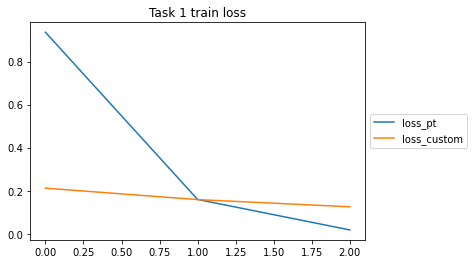

In [186]:
f = plt.figure()
plt.title('Task 1 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [187]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 1 выполнено успешно')
else:
    print('Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task1 = loss_history

Задание 1 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной
Суммарная ошибка = 0.8323


### Задание 2

Требуется реализовать классы пакетной нормализации **BatchNorm2d** и слоя выборки усреднением **AvgPool**. Реализовать класс модели, идентичной эталонной TorchGradientModel2

Эталонная модель **TorchGradientModel2**, состоить из:
- Сверточный слой с 4 фильтрами размера $3\times3$;
- Пакетная нормализация;
- Функция активации [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- Выборки усреднением с ашгом 2 и размером окна 2
- Линейный слой с переменных количеством выходных нейронов

In [ ]:
class TorchGradientModel2(nn.Module):
    def __init__(self, num_classes=2, input_size=5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=0, bias=True)
        self.bn1 = nn.BatchNorm2d(4)
        self.act1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * int((input_size - 2) / 2) * int((input_size - 2) / 2), num_classes)
        # PyTorch автоматически применяет LogSoftmax при использовании CrossEntropyloss

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.flatten(x)
        x = self.fc1(x)

        return x

In [ ]:
learning_rate = 1
epochs = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2()

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
#         print(param)
        torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. При желании можете поэкспериментировать с другими, которые реализовали для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(batch) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
#     for param in torch_grad_model.named_parameters():
#         print(param)

    loss = ce(predict_y, labels)
    loss_history.loc[e, 'loss_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item()

    train_acc /= batch.shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

In [ ]:
class BatchNorm2d():
    def __init__(self, num_channels, gamma=1, beta=0, eps=1e-20):
        self.num_channels = num_channels
        # Применяем стандартные название полей для обновления весов, чтобы не переписывать код модели и оптимизатора
        self.W = torch.ones(num_channels)  # gamma
        self.b = torch.zeros(num_channels)  # beta
        self.eps = eps
        
        self.dW = torch.zeros(num_channels)
        self.db = torch.zeros(num_channels)

        self.cache = None
        
    def forward(self, x, debug=True):
        raise NotImplementedError
    
    def backward(self, dout):
        raise NotImplementedError

In [ ]:
class AvgPool():
    def __init__(self, filter_size, stride):
        self.f = filter_size
        self.s = stride
        self.cache = None

    def forward(self, X):
        """
        Прямой проход для усредняющего пулинга.
        
        Аргументы
        ---------
        X : torch.tensor, shape = (m, n_C, n_H_prev, n_W_prev)
        
        Возвращает
        ----------
        torch.tensor, shape = (m, n_C, n_H, n_W)
        """
        
        m, n_C, n_H_prev, n_W_prev = X.shape
        
        # Посчитаем новый размеры по формуле из доков AvgPool2d
        n_H = int(1 + (n_H_prev - self.f) / self.s)
        n_W = int(1 + (n_W_prev - self.f) / self.s)
        
        Z = torch.zeros((m, n_C, n_H, n_W))
        
        for i in range(m):
            cur_batch_elem = X[i]
            for h in range(n_H):
                for w in range(n_W):
                    # Определим границы текущего окна
                    top_left_h = h * self.s
                    top_left_w = w * self.s
                    bottom_right_h = top_left_h + self.f
                    bottom_right_w = top_left_w + self.f
                    
                    for c in range(n_C):
                        window = cur_batch_elem[c, top_left_h:bottom_right_h, 
                                                top_left_w:bottom_right_w]
                        Z[i, h, w, c] = torch.mean(window)
                        
        return Z

    def backward(self, dout):
        raise NotImplementedError

In [ ]:
class CustomModel2():

    def __init__(self, input_size = 5, num_classes = 2):
        # ВПИСАТЬ МОДУЛИ СЕТИ ЗДЕСЬ
        
        self.layers = [self.conv1, self.bn1, self.fc1]

    def forward(self, x):
        raise NotImplementedError
        
    def backward(self, deltaL):
        raise NotImplementedError


    def get_params(self):
        params = {}
        for i, layer in enumerate(self.layers):
            params['W' + str(i+1)] = layer.W
            params['b' + str(i+1)] = layer.b

        return params

    def set_params(self, params):
        for i, layer in enumerate(self.layers):
            layer.W = params['W'+ str(i+1)]
            layer.b = params['b' + str(i+1)]

In [ ]:
def train_custom_model2(X, y, epochs, num_classes):
    y = one_hot_encoding(labels, num_classes) # преобразуем число в эталоне в унитарный код.
    
    model = CustomModel2(input_size = X.shape[-1], num_classes=num_classes)
    cost = CrossEntropyLoss()
    
    params = model.get_params()

    optimizer = SGD(lr = learning_rate, params = model.get_params())      

    t = trange(epochs)
    
    for e in t:
        train_loss = 0
        train_acc = 0 
  
        y_pred = model.forward(X)
        loss, deltaL = cost.get(y_pred, y)
        grads = model.backward(deltaL)
        params = optimizer.update_params(grads)
        model.set_params(params)

        train_loss += loss.item()
        train_acc = torch.sum(torch.argmax(predict_y, axis=1) == labels).item() / X.shape[0]
        
        loss_history.loc[e, 'loss_custom'] = train_loss
        t.set_postfix(loss=train_loss, acc=train_acc)

In [ ]:
train_custom_model2(batch, labels, epochs, num_classes=2)

In [ ]:
f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute((loss_history.iloc[:,0].values-loss_history.iloc[:,1].values)).sum()
if error < 1e-3:
    print('Задание 2 выполнено успешно')
else:
    print('Задание 2 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

### Задание 3

Обучить ранее реализованную сеть **CustomModel2** на реальных данных из выборки digits.

In [ ]:
from sklearn import preprocessing
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import torchvision

In [ ]:
def get_data_numbers():
    # Загружаем выборку digits
    digits = load_digits(n_class=10, return_X_y=False, as_frame=False)

    # ПРОВЕСТИ НЕОБХОДИМЫЕ ПРЕОБРАЗОВАНИЯ
    
    return train_x, train_label, val_x, val_label

In [ ]:
train_x, train_label, val_x, val_label = get_data_numbers()

In [ ]:
learning_rate = 1
epochs = 10
num_classes = 10

# СТУДЕНТАМ:
# Сохраняйте историю эмпирического риска каждую эпоху в отдельном столбце loss_history 'loss_custom'
loss_history = pd.DataFrame(index=range(epochs), dtype=float)

torch_grad_model = TorchGradientModel2(num_classes, input_size=8)

# СТУДЕНТАМ:
# Используйте эти веса, чтобы инициализировать веса своей сети для точной воспроизводимости результатов
torch_model_params = []
temp_m = copy.deepcopy(torch_grad_model)
for param in temp_m.named_parameters():
    if param[0] in ('conv1.weight', 'conv1.bias', 'fc1.weight', 'fc1.bias'):
#         print(param)
        torch_model_params.append(param[1].clone().detach())

# СТУДЕНТАМ:
# При реализации своих слоёв не забывайте делить получившиеся градиенты по ошибкам на размер пакета (кол-во изображений для I-го слоя),
# чтобы эмулировать поведение CrossEntropyLoss с параметром reduction='mean'
ce = nn.CrossEntropyLoss(reduction='mean')

# Для эксперимента используется самый простой оптимизатор. При желании можете поэкспериментировать с другими, которые реализовали для 1-го задания
optimizer = torch.optim.SGD(torch_grad_model.parameters(), lr=learning_rate, momentum=0, dampening=0, weight_decay=0, nesterov=False)

torch_grad_model.train()
t = trange(epochs)
loss_hist_pt = []
for e in t:
    predict_y = torch_grad_model(train_x[0:10]) # для обучения используем весь пакет
    
#     Можете выводить веса сети для прямого сравнения со своей реализацей, 
#     for param in torch_grad_model.named_parameters():
#         print(param)

    loss = ce(predict_y, train_label[0:10])
    loss_history.loc[e, 'loss_train_pt'] = loss.item()
    
    # Градиенты нужно обнулять в каждой эпохе
    optimizer.zero_grad()
    loss.backward()
    
    # Градиенты так же можно выводить в текстовом виде для оценки хода обучения
#     print('Gradients')
#     for param in torch_grad_model.named_parameters():
#         print(param[0], param[1].grad)
    
    optimizer.step()
    
    train_acc = torch.sum(torch.argmax(predict_y, axis=1) == train_label[0:10]).item()

    train_acc /= train_x[0:10].shape[0]
    t.set_postfix(loss=loss.item(), accuracy=train_acc)

In [ ]:
def train_model(epochs, learning_rate, loss_history, train_x, train_label, val_x, val_label):
    raise NotImplementedError

In [ ]:
# loss_history = pd.DataFrame(index=range(epochs), dtype=float)
train_model(epochs, learning_rate, loss_history, train_x[0:10], train_label[0:10], val_x[0:10], val_label[0:10])

f = plt.figure()
plt.title('Task 2 train loss', color='black')
loss_history.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
# Эмпирический риск на всех эпохах должен совпадать с реализацией PyTorch
error = np.absolute(loss_history[['loss_train_custom']].to_numpy()-loss_history[['loss_train_pt']].to_numpy()).sum()
if error < 1e-3:
    print('Задание 3 выполнено успешно')
else:
    print('Задание 3 не выполнено. Эмпирический риск не совпадает в реализациях PyTorch и собственной')
print(f'Суммарная ошибка = {error:.4f}')
loss_history_task2 = loss_history

### Необязательное задание
Создать свою архитектуру свёрточной сети и обучиться на полной выборке digits, получив высокое качество классификации. Сравнить скорость и финальное качество обучения при применении разных алгоритмов обучения (SGD с моментом, Adam), регуляризации весов.